In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import datetime as dt

plt.style.use ('ggplot')

pd.options.display.float_format = '{:,.4f}'.format

## Functions

In [3]:
def rolling_regression_currencies(fx: str, df_fx: pd.DataFrame, var: list, rebal='weekly'):
    """
    Rolling regresion
    
    Parameters:
    ------------------
    fx: 'str'
    name of currency to regress
    df_fx: 'pd.DataFrame'
    dataframe with features and fx time series
    var: list
    name of features (regressors)
    rebal: str
    specify the periodicity of input info ['weekly','daily']
    default set to 'weekly'
    
    """
    
    # Rolling Window frecuency
    freq = dict(weekly=52, daily=365)[rebal]
    #print(freq)
    # Feature list with betas name
    betas_var = var.copy()
    betas_var.insert(0,'const')
    
    # Dataframes to store prediction and betas evolution
    pred = pd.DataFrame(index=df_fx.index)
    betas = pd.DataFrame(index=betas_var)
    
    start_year = df_fx.index[0].year
    end_year = df_fx.index[-1].year
    end_month = df_fx.index[-1].month
    end_day = df_fx.index[-1].day
    end_week = df_fx.index[-1].week
    
    if freq == 365:
        for year in range(start_year+1, end_year+1):
            for month in range(1, 13):
    
                year0 = year - 1
                #numero = pd.Timestamp(f'{year}-{month}-01') + pd.DateOffset(days=30)
                # Take last year of info
                sub_data = df.loc[(df.index <= f'{year}-{month}-01') & (df.index > f'{year0}-{month}-01')]
                # Select features
                X = sub_data[var]
                # Add constant
                X = sm.add_constant(X)
                # Select feature to explain 
                y = sub_data[f'{fx}']
                # Fit model
                model = sm.OLS(y, X).fit()
    
                # Add information to dataframes
                df.loc[sub_data.index, f'e_{fx}'] = model.predict(X)
                pred = pd.concat([pred,model.predict(X).rename(f'{year}-0{month}')],axis=1)
                betas = pd.concat([betas,model.params.rename(f'{year}-0{month}')],axis=1)
    
                # Condition to stop loop before current year end
                if (year == end_year) & (month == end_month+1):
                    break
    
    if freq == 52:
        for year in range(start_year+1, end_year+1):
            for week in range(1, 53):
    
                year0 = year - 1
                #numero = pd.Timestamp(f'{year}-{month}-01') + pd.DateOffset(days=30)
                
                # Calculate the ISO week number for the given year and week
                iso_week = pd.Timestamp(f'{year}-01-04').isocalendar()[1]  # ISO week number of January 1st in the given year
                #print(iso_week,week)
                start_iso_week = pd.Timestamp.fromisocalendar(year, iso_week + week - 1, 1)  # Start of the ISO week
                end_iso_week = pd.Timestamp.fromisocalendar(year, iso_week + week - 1, 5)  # End of the ISO week
            
                # Take last year of info
                sub_data = df_fx.loc[(df_fx.index <= end_iso_week) & (df_fx.index > end_iso_week+pd.DateOffset(days=-365))]
                # Select features
                X = sub_data[var]
                # Add constant
                X = sm.add_constant(X)
                # Select feature to explain 
                y = sub_data[f'{fx}']
                # Fit model
                model = sm.OLS(y, X).fit()
    
                # Add information to dataframes
                df_fx.loc[sub_data.index, f'e_{fx}'] = model.predict(X)
                pred = pd.concat([pred,model.predict(X).rename(f'{year}-0{week}')],axis=1)
                betas = pd.concat([betas,model.params.rename(f'{year}-0{week}')],axis=1)
    
                # Condition to stop loop before current year end
                if (year == end_year) & (week == end_week+1):
                    break
    return model.summary(), pred, betas

In [4]:
def signal_creation(fx: str, df_fx: pd.DataFrame, rebal='weekly'):
    
    # Rolling Window frecuency
    freq = dict(weekly=26, daily=180)[rebal]
    
    # Calculate error
    df_fx['dif'] = df_fx[f'{fx}'] - df_fx[f'e_{fx}']

    # Rolling Statistics
    rolling_results = df_fx['dif'].rolling(window=26).agg(['mean', 'std'])
    df_fx = df_fx.merge(rolling_results, left_index=True, right_index=True, suffixes=('', '_rolling'))

    # Generate Signal
    df_fx['señal'] = np.where(df_fx['dif'] > df_fx['mean'] + df_fx['std'], -1,
                            np.where(df_fx['dif'] < df_fx['mean'] - df_fx['std'], 1, 0))

    # Generate Effectiveness Index
    df_fx['indice'] = 100
    #df.loc[df.index[365:], 'indice'] = np.nan
    df_fx['indice'] = df_fx['indice'].ffill() * (1 + df_fx['retorno'] * df_fx['señal'].shift(1)).cumprod()

    # Generate std bands
    df_fx['over'] = df_fx[f'e_{fx}']+df_fx['mean']+df_fx['std']
    df_fx['under'] = df_fx[f'e_{fx}']+df_fx['mean']-df_fx['std']
    
    return df_fx

In [5]:
def currency_plots(fx: str, df_fx: pd.DataFrame, yrs: int, rebal='weekly'):
    
    # Rolling Window frecuency
    freq = dict(weekly=52, daily=365)[rebal]
    
    # Create buy and sell dataframe markets
    idx = df_fx[[]].tail(freq*yrs)
    idx = idx.merge(df_fx[df_fx['señal'] == 1][f'{fx}'], on='Dates', how='left')
    idx = idx.merge(df_fx[df_fx['señal'] == -1][f'{fx}'], on='Dates', how='left')
    idx.columns = ['buy','sell']
    
    #fig, ax = plt.subplots()
    #ax2 = ax.twiny()
    
    # Plot currency and estimated level
    df_fx[[f'{fx}',f'e_{fx}']].tail(freq*yrs).plot(figsize=(10,6));
    
    # Plot 1-std bands
    plt.fill_between(df_fx.tail(freq*yrs).index,df_fx['under'].tail(freq*yrs)
                     ,df_fx['over'].tail(freq*yrs),color='navy',alpha=0.4);
    
    # Add markers to plot
    plt.plot(idx['buy'], '^', ms=7, label='Buy Signal', color='green', alpha = 0.4);
    plt.plot(idx['sell'], '^', ms=7, label='Sell Signal', color='red', alpha = 0.4);
    
    # Add formating to Y axis and title
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);
    plt.title(f'e_{fx} bands vs {fx}')
    plt.legend()
    plt.show()
    print(' ')
    
    df_fx['señal'].tail(freq*yrs).plot(figsize=(10,6))
    plt.title(f'usd{fx} Long/Short Signal');
    plt.show()
    print(' ')
    
    (df_fx['indice']-100).plot(figsize=(10,6))
    plt.title(f'Cummulative return {fx} Strategy');
    plt.show()
    print(' ')
    

In [6]:
def currency_strategy(fx: str, df_fx: pd.DataFrame, var: list, yrs: int, rebal='weekly'):
    """
    Currency Model
    
    Parameters:
    ------------------
    fx: 'str'
    name of currency to regress
    df_fx: 'pd.DataFrame'
    dataframe with features and fx time series
    var: list
    name of features (regressors)
    yrs: int
    Number of years to plot
    rebal: str
    specify the periodicity of input info ['weekly','daily']
    default set to 'weekly'
    """
    
    fx_summ, fx_pre, fx_betas = rolling_regression_currencies(fx=fx, df_fx=df_fx, var= var, rebal=rebal)
    df_fx = signal_creation(fx=fx, df_fx=df_fx, rebal=rebal)
    currency_plots(fx=fx, df_fx=df_fx, yrs=yrs, rebal=rebal)
    
    return fx_summ, fx_pre, fx_betas, df_fx

## Latam Currencies Estimate using weekly info

In [17]:
# File path with input excel
#
file_path = r'2019.01.14 Monedas Semanal.xlsx'

# Reading information, each column is a sheet
df_currencies = pd.read_excel(file_path, sheet_name=None, skiprows=4, index_col=1)

# For loop to clean unwanted information 
for l in list(df_currencies.keys()):    
    # Create a boolean array indicating which columns contain either "Unnamed" or "PX_LAST"
    cols_to_drop = df_currencies[l].columns[df_currencies[l].columns.str.contains('Unnamed|PX_LAST')]
    # Drop filtered columns and NAs
    df_currencies[l].drop(cols_to_drop,axis=1,inplace=True)
    df_currencies[l].dropna(inplace=True)

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [ ]:
df_brasil_w = df_currencies['Brasil'].copy()
df_chile_w = df_currencies['Chile'].copy()
df_colombia_w = df_currencies['Colombia'].copy()
df_mexico_w = df_currencies['México'].copy()
df_peru_w = df_currencies['Perú'].copy()
df_uruguay_w = df_currencies['Uruguay'].copy()

del df_currencies

## Uruguay

#### Feature engineering

In [ ]:
# Returns
df_uruguay_w['retorno'] = df_uruguay_w['uyu'].pct_change()

# Generate Variables
df_uruguay_w['uyu_curve'] = df_uruguay_w['uyu_10y'] - df_uruguay_w['uyu_3y']
df_uruguay_w['us_curve'] = df_uruguay_w['us_10y'] - df_uruguay_w['us_2y']
df_uruguay_w['expansion'] = df_uruguay_w['uyu_curve'] - df_uruguay_w['us_curve']
df_uruguay_w['e_uyu'] = 0

df_uruguay_w.fillna(0,inplace=True)

#### Signal and performance

In [ ]:
var_uyu=['expansion','oil','vol']
#uy_summ, uy_pre, uy_betas = rolling_regression_currencies('uyu',df_uruguay_w, var1,'weekly')

In [ ]:
uy_summ, uy_pre, uy_betas, df_uruguay_w = currency_strategy('uyu',df_uruguay_w, var_uyu,3 ,'weekly');

In [ ]:
df_uruguay_w[['uyu','e_uyu','dif','mean','std','señal','retorno','indice','under','over']].tail()

## Mexico 

#### Feature engineering

In [ ]:
# Returns
df_mexico_w['r_local'] = df_mexico_w['mexbol'].pct_change(52)
df_mexico_w['r_us'] = df_mexico_w['spx'].pct_change(52)
df_mexico_w['r_global'] = df_mexico_w['global'].pct_change(52)
df_mexico_w['r_em'] = df_mexico_w['em'].pct_change(52)
df_mexico_w['retorno'] = df_mexico_w['mxn'].pct_change()

# Generate Variables
df_mexico_w['dif_tasas'] = df_mexico_w['mx_1y1y'] - df_mexico_w['us_1y1y']
df_mexico_w['mx_curve'] = df_mexico_w['mx_10y'] - df_mexico_w['mx_2y']
df_mexico_w['us_curve'] = df_mexico_w['us_10y'] - df_mexico_w['us_2y']
df_mexico_w['expansion'] = df_mexico_w['mx_curve'] - df_mexico_w['us_curve']
df_mexico_w['performance'] = df_mexico_w['r_local'] - df_mexico_w['r_us']
df_mexico_w['risk'] = df_mexico_w['r_em'] - df_mexico_w['r_global']
df_mexico_w['e_mxn'] = 0

df_mexico_w.fillna(0,inplace=True)

#### Signal and performance

In [ ]:
var_mxn=['dif_tasas', 'expansion', 'performance', 'risk', 'oil']

In [ ]:
mex_summ, mex_pre, mex_betas, df_mexico_w = currency_strategy('mxn',df_mexico_w, var_mxn,3 ,'weekly');

In [ ]:
df_mexico_w[var_mxn].tail()

In [ ]:
df_mexico_w[['mxn','e_mxn','dif','mean','std','señal','retorno','indice','under','over']].tail()

## COP Estimate using daily info

In [4]:
act_year = dt.datetime.today().year
act_year

2024

In [6]:
# Read Excel file
#C:\Users\luis.gaitan\SURA INVESTMENT MANAGEMENT S.A\Estrategias de Inversion - Documentos\Local\Latam\Moneda\Modelo Diario\
file_path = r"2018.10.12 Monedas Diario.xlsx"
df = pd.read_excel(file_path, sheet_name="Colombia", usecols="B:S", skiprows=4, index_col=0)
df = df.iloc[1:]

In [8]:
start_year = df.index[0].year
end_year = df.index[-1].year
end_month = df.index[-1].month

In [10]:
end_month

11

In [12]:
df.index[-1].week

46

In [14]:
# Generate Returns
df['r_local'] = df['colcap'].pct_change(365)
df['r_us'] = df['spx'].pct_change(365)
df['r_global'] = df['global'].pct_change(365)
df['r_em'] = df['em'].pct_change(365)
#df['retorno'] = df['cop'].shift(-1) / df['cop'] - 1
df['retorno'] = df['cop'].pct_change()

# Generate Variables
df['dif_tasas'] = df['col_1y1y'] - df['us_1y1y']
df['col_curve'] = df['col_10y'] - df['col_2y']
df['us_curve'] = df['us_10y'] - df['us_2y']
df['expansion'] = df['col_10y'] - df['us_10y']
df['performance'] = df['r_local'] - df['r_us']
df['risk'] = df['r_em'] - df['r_us']
df['e_cop'] = 0

df.fillna(0,inplace=True)

In [16]:
var = ['dif_tasas', 'expansion', 'r_local', 'oil', 'r_em']
betas_var = var.copy()
betas_var.insert(0,'const')
betas_var

['const', 'dif_tasas', 'expansion', 'r_local', 'oil', 'r_em']

In [18]:
pred = pd.DataFrame(index=df.index)
betas = pd.DataFrame(index=betas_var)

# Rolling Regressions
for year in range(start_year+1, end_year+1):
    for month in range(1, 13):
        
        year0 = year - 1
        #numero = pd.Timestamp(f'{year}-{month}-01') + pd.DateOffset(days=30)
        # Take last year of info
        sub_data = df.loc[(df.index <= f'{year}-{month}-01') & (df.index > f'{year0}-{month}-01')]
        # Select features
        X = sub_data[var]
        # Add constant
        X = sm.add_constant(X)
        # Select feature to explain 
        y = sub_data['cop']
        # Fit model
        model = sm.OLS(y, X).fit()
        
        # Add information to dataframes
        df.loc[sub_data.index, 'e_cop'] = model.predict(X)
        pred = pd.concat([pred,model.predict(X).rename(f'{year}-0{month}')],axis=1)
        betas = pd.concat([betas,model.params.rename(f'{year}-0{month}')],axis=1)
        
        # Condition to stop loop before current year end
        if (year == end_year) & (month == end_month+1):
            break
        

C:\Users\user\AppData\Local\Temp\ipykernel_6032\1441892063.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1862.30574404 1862.30574404 1865.90487707 1859.18241302 1868.8087452
 1873.80608015 1867.87050313 1867.87050313 1867.87050313 1857.97018025
 1861.53012798 1872.44072034 1864.7887455  1866.24067068 1866.24067068
 1866.24067068 1862.87889826 1888.75793301 1866.5922643  1856.25823036
 1839.16307436 1839.16307436 1839.16307436 1840.91837443 1842.71705133
 1837.30441888 1837.48246168 1838.78213138 1838.78213138 1838.78213138
 1826.88265415 1824.61094341 1834.09629762 1834.9131037  1838.41126751
 1838.41126751 1838.41126751 1834.23480036 1839.18696992 1845.50035736
 1855.5055589  1856.39608129 1856.39608129 1856.39608129 1851.85408793
 1846.58313496 1852.50703919 1853.64817691 1854.47784602 1854.47784602
 1854.47784602 1858.33713476 1873.4895612  1849.87735705 1859.58700683
 1854.3744884  1854.37448

In [19]:
# Calculate error
df['dif'] = df['cop'] - df['e_cop']

# Rolling Statistics
rolling_results = df['dif'].rolling(window=180).agg(['mean', 'std'])
df = df.merge(rolling_results, left_index=True, right_index=True, suffixes=('', '_rolling'))

# Generate Signal
df['señal'] = np.where(df['dif'] > df['mean'] + df['std'], -1,
                        np.where(df['dif'] < df['mean'] - df['std'], 1, 0))

# Generate Effectiveness Index
df['indice'] = 100
#df.loc[df.index[365:], 'indice'] = np.nan
df['indice'] = df['indice'].ffill() * (1 + df['retorno'] * df['señal'].shift(1)).cumprod()

# Generate std bands
df['over'] = df['e_cop']+df['mean']+df['std']
df['under'] = df['e_cop']+df['mean']-df['std']
# Sort DataFrame
#df.sort_values(by=['Date', 'cop', 'e_cop'], inplace=True)

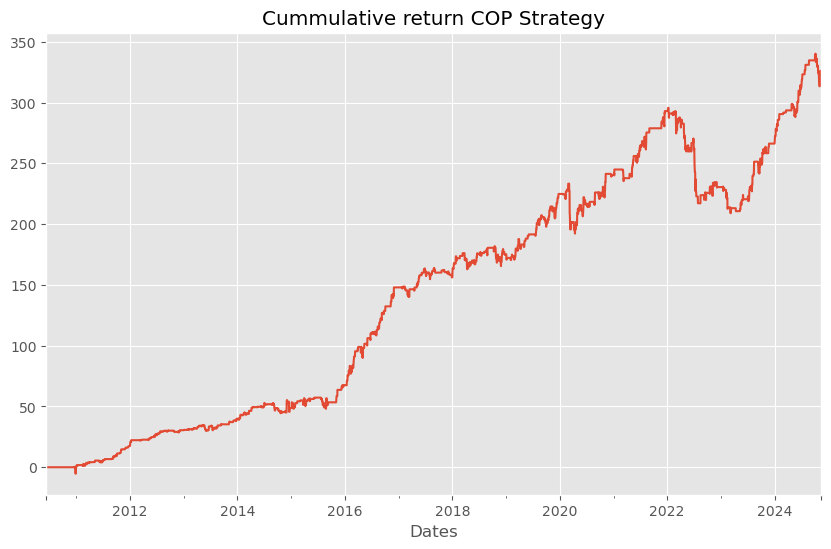

In [22]:
(df['indice']-100).plot(figsize=(10,6))
plt.title('Cummulative return COP Strategy');

<Axes: xlabel='Dates'>

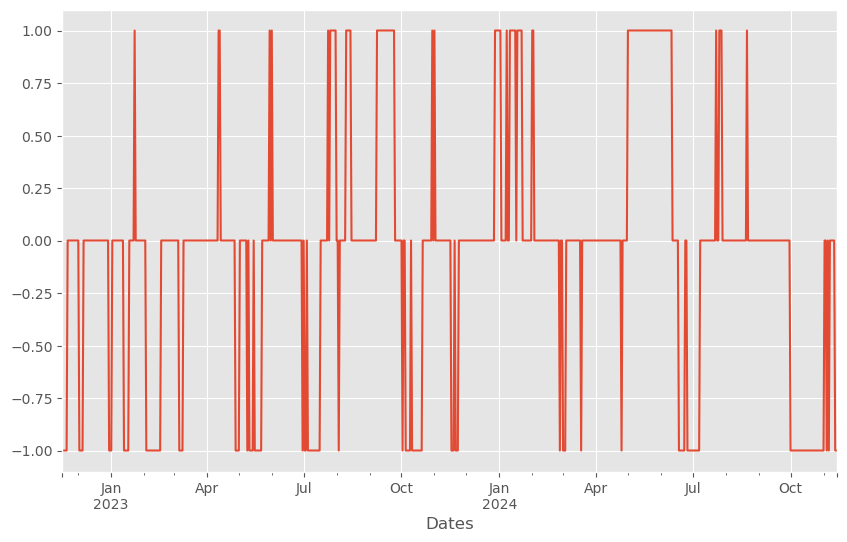

In [24]:
df['señal'].tail(365*2).plot(figsize=(10,6))

C:\Users\user\AppData\Local\Temp\ipykernel_6032\238120030.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);


Text(0.5, 1.0, 'e_COP bands vs COP')

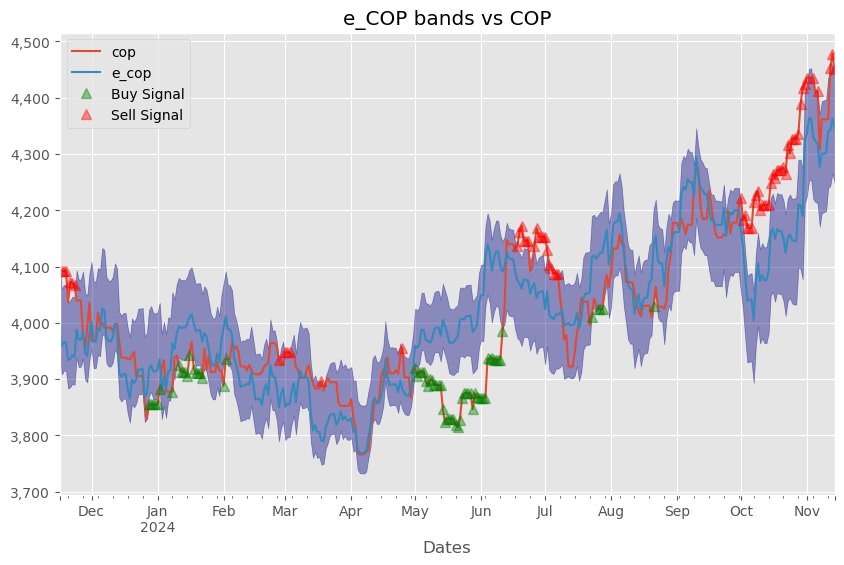

In [26]:
y = 1


(df[['cop','e_cop']].tail(365*y)).plot(figsize=(10,6));


plt.fill_between(df.tail(365*y).index,df['under'].tail(365*y),df['over'].tail(365*y),color='navy',alpha=0.4);

idx = df[[]].tail(365*y)
idx = idx.merge(df[df['señal'] == 1]['cop'],on='Dates',how='left')
idx = idx.merge(df[df['señal'] == -1]['cop'],on='Dates',how='left')

idx.columns = ['buy','sell']


plt.plot(idx['buy'], '^', ms=7, label='Buy Signal', color='green', alpha = 0.4);
plt.plot(idx['sell'], '^', ms=7, label='Sell Signal', color='red', alpha = 0.4);
plt.legend()
#plt.ylim(3_000, 5_500);
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);
plt.title('e_COP bands vs COP')

In [44]:
df[var].tail(15)

,dif_tasas,expansion,r_local,oil,r_em
Dates,,,,,
2024-10-15,4.9370,6.3063,0.1904,70.5800,-0.0263
2024-10-16,4.9561,6.3498,0.1948,70.3900,-0.0301
2024-10-17,4.9870,6.3554,0.1867,70.6700,-0.0132
2024-10-18,5.0187,6.4722,0.2101,69.2200,-0.0016
2024-10-19,5.0187,6.4722,0.2189,69.2200,0.0057
2024-10-20,5.0187,6.4722,0.2189,69.2200,0.0057
2024-10-21,5.0638,6.4674,0.2138,70.5600,-0.0035
2024-10-22,5.0775,6.5114,0.2125,72.0900,-0.0036
2024-10-23,5.0941,6.6174,0.1952,70.7700,-0.0192


In [46]:
df[['cop','e_cop','dif','mean','std','señal','retorno','indice','under','over']].tail(15)

,cop,e_cop,dif,mean,std,señal,retorno,indice,under,over
Dates,,,,,,,,,,
2024-10-15,"4,247.7500","4,147.8396",99.9104,-11.9372,86.2573,-1,0.0091,453.1641,"4,049.6450","4,222.1597"
2024-10-16,"4,264.1300","4,154.5911",109.5389,-11.4763,86.6849,-1,0.0039,451.4167,"4,056.4300","4,229.7997"
2024-10-17,"4,256.7400","4,139.7680",116.9720,-11.0004,87.1549,-1,-0.0017,452.1990,"4,041.6126","4,215.9225"
2024-10-18,"4,272.1000","4,159.0608",113.0392,-10.5463,87.5884,-1,0.0036,450.5673,"4,060.9261","4,236.1029"
2024-10-19,"4,272.1000","4,154.5785",117.5215,-10.1437,88.0110,-1,0.0000,450.5673,"4,056.4238","4,232.4457"
2024-10-20,"4,272.1000","4,154.5785",117.5215,-9.8081,88.3832,-1,0.0000,450.5673,"4,056.3871","4,233.1536"
2024-10-21,"4,276.2500","4,138.1813",138.0687,-9.5413,88.7580,-1,0.0010,450.1296,"4,039.8819","4,217.3979"
2024-10-22,"4,265.0700","4,121.2728",143.7972,-9.3902,88.9968,-1,-0.0026,451.3064,"4,022.8858","4,200.8794"
2024-10-23,"4,316.8300","4,156.4092",160.4208,-8.8349,89.7439,-1,0.0121,445.8295,"4,057.8305","4,237.3182"


In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cop   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     146.2
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           4.14e-84
Time:                        15:57:01   Log-Likelihood:                -2077.2
No. Observations:                 363   AIC:                             4166.
Df Residuals:                     357   BIC:                             4190.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4902.7490    119.664     40.971      0.000    4667.413    5138.085
dif_tasas    -86.3074     19.379     -4.454      0.000    -124.419     -48.195
expansion     92.7151     21.029      4.409      0.000      51.358     134.072
r_local      -49.0899     42.024     -1.168      0.244    -131.736      33.557
oil          -13.0190      0.881    -14.781      0.000     -14.751     -11.287
r_em        -558.9377     58.717     -9.519      0.000    -674.412    -443.464
==============================================================================
Omnibus:                        0.497   Durbin-Watson:                   0.118
Prob(Omnibus):                  0.780   Jarque-Bera (JB):                0.575
Skew:                          -0.084   Prob(JB):                        0.750
Kurtosis:                       2.902   Cond. No.                     2.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
df[['cop','e_cop','dif','mean','std','señal','retorno','indice']].to_excel('daily_cop_model.xlsx')
betas.to_excel('betas_hist_daily.xlsx')
pred.to_excel('loop_predict_daily.xlsx')

### Old Code